Before running, make sure that
* You have installed [coin](https://www.coin-or.org/download/binary/CoinAll/)
* You are running this notebook in a dedicated conda environment (create a new environment with conda, e.g.: `conda create --name epcm`), as required by oemof
* You have installed the following packages in the dedicated environment:
    * pandas">=0.23"
    * numpy=">=1.13"
    * sqlite3
    * oemof
    * matplotlib

Import packages

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import logging
import json
import sqlite3
import os
import matplotlib.pyplot as plt
import importlib

In [2]:
package_path = r"D:\DATA\g.peronato\dev\quartier_epcm\input_output"
sys.path.append(package_path)
print("Current working directory: ", os.getcwd())

Current working directory:  D:\DATA\g.peronato\dev\quartier_epcm\input_output\notebooks


Change the working directoy, if you like. This is where the output files of the model will be saved

In [3]:
Run = False
if Run:
    os.chdir(r'D:\DATA\g.peronato\dev\quartier_epcm\input_output')
else:
    print("not changing")
Run = False
print("Current working directory: ", os.getcwd())

not changing
Current working directory:  D:\DATA\g.peronato\dev\quartier_epcm\input_output\notebooks


Import the input_output modules and oemof

In [4]:
from input_output import *
from input_output import utils
from oemof.outputlib import views

In [5]:
# Autoreload extension for the module input_output, this is useful in development mode in case we change the code
%load_ext autoreload
%aimport input_output
%aimport input_output.utils
%aimport 

Modules to reload:
input_output input_output.utils

Modules to skip:



Load the database

In [6]:
# The package comes with a precomputed input-output database based on Eurostat data
# sqlite db located at : input_output/data/eurostat/eurostat_activities.db
# If you want to rebuild the db from eurostat data, use :

# Default emissions from EUROSTAT
#eurostat.convert_eurostat_data()

# Emissions from EUROSTAT energy use and ADEME emission factors
#eurostat.convert_eurostat_data(emissions_source="custom")

# Load all background production activities of the eurostat input-output database
db_filename = os.path.join(package_path, 'input_output', 'data', 'eurostat', 'eurostat_activities.db')
connection = sqlite3.connect(db_filename)
query = """SELECT * FROM eurostat_activities WHERE type = 'production'"""
result = connection.execute(query, ()).fetchall()
connection.close()


Initialize the system

In [7]:
# Initialize the LCA system with one timestep
def initialize():
    global s
    time_index = pd.date_range('1/1/2020', periods=1, freq='H')
    s = System(time_index)
initialize()

In [8]:
# Add territories to the system
def add_territories():
    global s
    s.add_territories([
        {
            'id': 'row', # row = rest of the world
            'slack': {
                'has_slack': True, # les résultats s'adaptent
                'source_costs': 1e9, # source infinie
                'sink_costs': 1e9 # puit infini
           },
            'exchange_costs': {
                'france': 1.0, # distance avec la France
                'neighborhood': 3.0 # distance plus grande avec le row : les échanges vont se faire d'abord avec la France
            }
        },
        {
            'id': 'france',
            'slack':  {
                'has_slack': False # les résultats ne s'adaptent pas
            },
            'exchange_costs': {
                'row': 1.0,
                'neighborhood': 1.0
            }
        },
        {
            'id': 'neighborhood',
            'slack':  {
                'has_slack': False
            },
            'exchange_costs': {
                'row': 3.0, # distance plus grande avec le row : les échanges vont se faire d'abord avec la France
                'france': 1.0
            }
        }
    ])
add_territories()

In [9]:
p_list = []
for r in result:
    p_list.append([r[1], r[2]])
p_list

[['CPA_A01', 'france'],
 ['CPA_A02', 'france'],
 ['CPA_A03', 'france'],
 ['CPA_B', 'france'],
 ['CPA_C10-12', 'france'],
 ['CPA_C13-15', 'france'],
 ['CPA_C16', 'france'],
 ['CPA_C17', 'france'],
 ['CPA_C18', 'france'],
 ['CPA_C19', 'france'],
 ['CPA_C20', 'france'],
 ['CPA_C21', 'france'],
 ['CPA_C22', 'france'],
 ['CPA_C23', 'france'],
 ['CPA_C24', 'france'],
 ['CPA_C25', 'france'],
 ['CPA_C26', 'france'],
 ['CPA_C27', 'france'],
 ['CPA_C28', 'france'],
 ['CPA_C29', 'france'],
 ['CPA_C30', 'france'],
 ['CPA_C31_32', 'france'],
 ['CPA_C33', 'france'],
 ['CPA_D', 'france'],
 ['CPA_E36', 'france'],
 ['CPA_E37-39', 'france'],
 ['CPA_F', 'france'],
 ['CPA_G45', 'france'],
 ['CPA_G46', 'france'],
 ['CPA_G47', 'france'],
 ['CPA_H49', 'france'],
 ['CPA_H50', 'france'],
 ['CPA_H51', 'france'],
 ['CPA_H52', 'france'],
 ['CPA_H53', 'france'],
 ['CPA_I', 'france'],
 ['CPA_J58', 'france'],
 ['CPA_J59_60', 'france'],
 ['CPA_J61', 'france'],
 ['CPA_J62_63', 'france'],
 ['CPA_K64', 'france'],
 ['CPA

In [10]:
def add_production():
    global s
    p_list = []
    for r in result:
        p_list.append([r[1], r[2]])
    # Add the activities to the LCA system, with a large capacity
    # (to be able to match the level of demand)
    for p in p_list:
        print(p[0],p[1])
        prod = Activity(
            label = p[0] + '_prod_' + p[1],
            territory = p[1],
            fixed = False
        ) 

        prod.load_io_from_db(
            service = p[0],
            territory = p[1],
            capacity = 1e6,
            db_filename = db_filename
        ) 

        s.add_activities([prod])
    return p_list
p_list = add_production()

CPA_A01 france
CPA_A02 france
CPA_A03 france
CPA_B france
CPA_C10-12 france
CPA_C13-15 france
CPA_C16 france
CPA_C17 france
CPA_C18 france
CPA_C19 france
CPA_C20 france
CPA_C21 france
CPA_C22 france
CPA_C23 france
CPA_C24 france
CPA_C25 france
CPA_C26 france
CPA_C27 france
CPA_C28 france
CPA_C29 france
CPA_C30 france
CPA_C31_32 france
CPA_C33 france
CPA_D france
CPA_E36 france
CPA_E37-39 france
CPA_F france
CPA_G45 france
CPA_G46 france
CPA_G47 france
CPA_H49 france
CPA_H50 france
CPA_H51 france
CPA_H52 france
CPA_H53 france
CPA_I france
CPA_J58 france
CPA_J59_60 france
CPA_J61 france
CPA_J62_63 france
CPA_K64 france
CPA_K65 france
CPA_K66 france
CPA_L68A france
CPA_L68B france
CPA_M69_70 france
CPA_M71 france
CPA_M72 france
CPA_M73 france
CPA_M74_75 france
CPA_N77 france
CPA_N78 france
CPA_N79 france
CPA_N80-82 france
CPA_O france
CPA_P france
CPA_Q86 france
CPA_Q87_88 france
CPA_R90-92 france
CPA_R93 france
CPA_S94 france
CPA_S95 france
CPA_S96 france
CPA_A01 row
CPA_A02 row
CPA_C10-

### Exemple 1 Average French

In [11]:
initialize()
add_territories()
add_production()

CPA_A01 france
CPA_A02 france
CPA_A03 france
CPA_B france
CPA_C10-12 france
CPA_C13-15 france
CPA_C16 france
CPA_C17 france
CPA_C18 france
CPA_C19 france
CPA_C20 france
CPA_C21 france
CPA_C22 france
CPA_C23 france
CPA_C24 france
CPA_C25 france
CPA_C26 france
CPA_C27 france
CPA_C28 france
CPA_C29 france
CPA_C30 france
CPA_C31_32 france
CPA_C33 france
CPA_D france
CPA_E36 france
CPA_E37-39 france
CPA_F france
CPA_G45 france
CPA_G46 france
CPA_G47 france
CPA_H49 france
CPA_H50 france
CPA_H51 france
CPA_H52 france
CPA_H53 france
CPA_I france
CPA_J58 france
CPA_J59_60 france
CPA_J61 france
CPA_J62_63 france
CPA_K64 france
CPA_K65 france
CPA_K66 france
CPA_L68A france
CPA_L68B france
CPA_M69_70 france
CPA_M71 france
CPA_M72 france
CPA_M73 france
CPA_M74_75 france
CPA_N77 france
CPA_N78 france
CPA_N79 france
CPA_N80-82 france
CPA_O france
CPA_P france
CPA_Q86 france
CPA_Q87_88 france
CPA_R90-92 france
CPA_R93 france
CPA_S94 france
CPA_S95 france
CPA_S96 france
CPA_A01 row
CPA_A02 row
CPA_C10-

[['CPA_A01', 'france'],
 ['CPA_A02', 'france'],
 ['CPA_A03', 'france'],
 ['CPA_B', 'france'],
 ['CPA_C10-12', 'france'],
 ['CPA_C13-15', 'france'],
 ['CPA_C16', 'france'],
 ['CPA_C17', 'france'],
 ['CPA_C18', 'france'],
 ['CPA_C19', 'france'],
 ['CPA_C20', 'france'],
 ['CPA_C21', 'france'],
 ['CPA_C22', 'france'],
 ['CPA_C23', 'france'],
 ['CPA_C24', 'france'],
 ['CPA_C25', 'france'],
 ['CPA_C26', 'france'],
 ['CPA_C27', 'france'],
 ['CPA_C28', 'france'],
 ['CPA_C29', 'france'],
 ['CPA_C30', 'france'],
 ['CPA_C31_32', 'france'],
 ['CPA_C33', 'france'],
 ['CPA_D', 'france'],
 ['CPA_E36', 'france'],
 ['CPA_E37-39', 'france'],
 ['CPA_F', 'france'],
 ['CPA_G45', 'france'],
 ['CPA_G46', 'france'],
 ['CPA_G47', 'france'],
 ['CPA_H49', 'france'],
 ['CPA_H50', 'france'],
 ['CPA_H51', 'france'],
 ['CPA_H52', 'france'],
 ['CPA_H53', 'france'],
 ['CPA_I', 'france'],
 ['CPA_J58', 'france'],
 ['CPA_J59_60', 'france'],
 ['CPA_J61', 'france'],
 ['CPA_J62_63', 'france'],
 ['CPA_K64', 'france'],
 ['CPA

Create a demand activity
with input-output flows taken from the P3_S14 activity
(average monetary demand for services, per person)

In [12]:
# French
cons_hh = Activity(
    label = 'households',
    territory = 'france',
    fixed = True
	
)

cons_hh.load_io_from_db(
    service = 'P3_S14',
    territory = 'france',
    capacity = np.array([1.0]),
    db_filename = db_filename
)
s.add_activities([cons_hh])

D:\DATA\g.peronato\dev\quartier_epcm\input_output\input_output\activity.py:42: UserWarning: The unit for P3_S14 should be'users'
  warnings.warn("The unit for {} should be'users'".format(self.label))


Setup and solve the input-output LCA system

In [13]:
s.setup_market_links()
s.setup_market_sources_and_sinks()
s.balance()

utils.extract_footprint(s, 0, package_path)

Solving system
Solver log file: 'D:\DATA\Adminlocal\AppData\Local\Temp\tmp2th1n8sy.cbc.log'
Solver solution file: 'D:\DATA\Adminlocal\AppData\Local\Temp\tmp0f60ptoo.pyomo.soln'
Solver problem files: ('D:\\DATA\\Adminlocal\\AppData\\Local\\Temp\\tmp0f60ptoo.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.8.8 
Build Date: Dec 23 2013 
Revision Number: 1998 

command line - C:\Program Files (x86)\COIN-OR\1.7.4\win32-msvc11\bin\cbc.exe -printingOptions all -import D:\DATA\Adminlocal\AppData\Local\Temp\tmp0f60ptoo.pyomo.lp -stat=1 -solve -solu D:\DATA\Adminlocal\AppData\Local\Temp\tmp0f60ptoo.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 210 (-10151) rows, 686 (-10049) columns and 10602 (-20219) elements
Statistics for presolved model


Problem has 210 rows, 686 columns (560 with objective) and 10602 elements
There are 140 singletons with objective 
Column breakdown:
0 of type 0.0->inf, 686 of type 0.0->up, 0 of type lo->inf, 
0 of typ

Read the results

In [14]:
footprint = pd.read_excel("footprint.xlsx",index_col=[0,1,2,3]).reset_index()

In [15]:
footprint

product_id    code                                           label_fr  \
0      CPA_A01       A  Culture et production animale, chasse et servi...   
1      CPA_A01       A  Culture et production animale, chasse et servi...   
2      CPA_A02       A            Sylviculture et exploitation forestière   
3      CPA_A02       A            Sylviculture et exploitation forestière   
4      CPA_A03       A                               Pêche et aquaculture   
..         ...     ...                                                ...   
127     HH_TRA     TRA                 Activités de transport des ménages   
128     P3_S13  P3_S13  Dépenses de consommation finale par les admini...   
129     P3_S13  P3_S13  Dépenses de consommation finale par les admini...   
130     P3_S15  P3_S15  Dépense de consommation finale par organisatio...   
131     P3_S15  P3_S15  Dépense de consommation finale par organisatio...   

    territory    households  
0      france  2.416963e+02  
1         row  4.080034e+02  
2      france  6.310675e+00  
3         row  5.365138e-01  
4      france  6.622221e+00  
..        ...           ...  
127    france  1.105637e+03  
128    france -3.855306e-12  
129       row  0.000000e+00  
130    france  0.000000e+00  
131       row  0.000000e+00  

[132 rows x 5 columns]

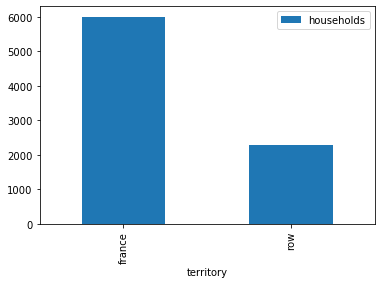

In [16]:
footprint.groupby("territory").sum().plot(kind="bar")

In [17]:
# Get description per macro-category of activities (A to T)
CPA = pd.read_csv(os.path.join(package_path,"input_output","data","CPA_2_1_20191218_124531.csv"))
footprint = pd.merge(footprint,CPA[["Description","Code"]], left_on="code", right_on = "Code", how="left")
footprint["CodeDes"] = footprint['Code'] + " - " + footprint['Description']
footprint.loc[footprint["CodeDes"].isna(),"CodeDes"] = footprint["code"]

In [18]:
footprint[footprint.code == "E"]

product_id code                                           label_fr  \
48     CPA_E36    E          Captage, traitement et distribution d'eau   
49     CPA_E36    E          Captage, traitement et distribution d'eau   
50  CPA_E37-39    E  Collecte et traitement des eaux usées, gestion...   
51  CPA_E37-39    E  Collecte et traitement des eaux usées, gestion...   

   territory  households                                        Description  \
48    france   14.688034  WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND R...   
49       row    0.000000  WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND R...   
50    france  115.354408  WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND R...   
51       row   10.501989  WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND R...   

   Code                                            CodeDes  
48    E  E - WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT A...  
49    E  E - WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT A...  
50    E  E - WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT A...  
51    E  E - WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT A...

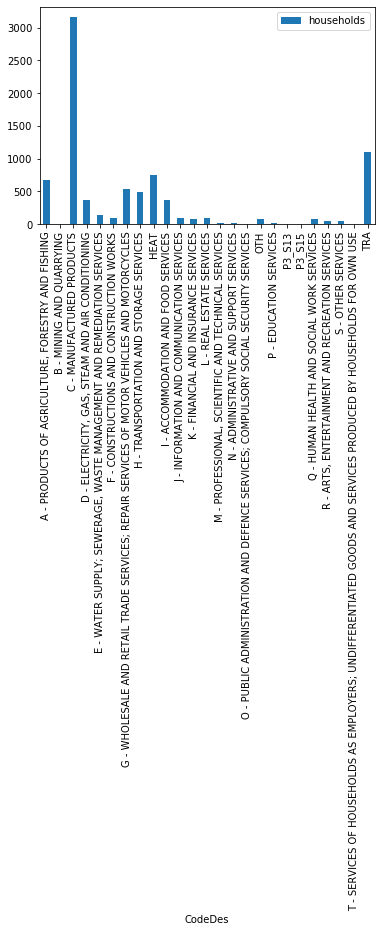

In [19]:
footprint.groupby("CodeDes").sum().plot(kind="bar")

In [20]:
print("Total footprint of the average French: ", int(round(footprint.households.sum())), "kg")

Total footprint of the average French:  8286 kg


### Example 2 - Add local production in the neighborhood

In [95]:
initialize()
add_territories()
add_production()

CPA_A01 france
CPA_A02 france
CPA_A03 france
CPA_B france
CPA_C10-12 france
CPA_C13-15 france
CPA_C16 france
CPA_C17 france
CPA_C18 france
CPA_C19 france
CPA_C20 france
CPA_C21 france
CPA_C22 france
CPA_C23 france
CPA_C24 france
CPA_C25 france
CPA_C26 france
CPA_C27 france
CPA_C28 france
CPA_C29 france
CPA_C30 france
CPA_C31_32 france
CPA_C33 france
CPA_D france
CPA_E36 france
CPA_E37-39 france
CPA_F france
CPA_G45 france
CPA_G46 france
CPA_G47 france
CPA_H49 france
CPA_H50 france
CPA_H51 france
CPA_H52 france
CPA_H53 france
CPA_I france
CPA_J58 france
CPA_J59_60 france
CPA_J61 france
CPA_J62_63 france
CPA_K64 france
CPA_K65 france
CPA_K66 france
CPA_L68A france
CPA_L68B france
CPA_M69_70 france
CPA_M71 france
CPA_M72 france
CPA_M73 france
CPA_M74_75 france
CPA_N77 france
CPA_N78 france
CPA_N79 france
CPA_N80-82 france
CPA_O france
CPA_P france
CPA_Q86 france
CPA_Q87_88 france
CPA_R90-92 france
CPA_R93 france
CPA_S94 france
CPA_S95 france
CPA_S96 france
CPA_A01 row
CPA_A02 row
CPA_C10-

[['CPA_A01', 'france'],
 ['CPA_A02', 'france'],
 ['CPA_A03', 'france'],
 ['CPA_B', 'france'],
 ['CPA_C10-12', 'france'],
 ['CPA_C13-15', 'france'],
 ['CPA_C16', 'france'],
 ['CPA_C17', 'france'],
 ['CPA_C18', 'france'],
 ['CPA_C19', 'france'],
 ['CPA_C20', 'france'],
 ['CPA_C21', 'france'],
 ['CPA_C22', 'france'],
 ['CPA_C23', 'france'],
 ['CPA_C24', 'france'],
 ['CPA_C25', 'france'],
 ['CPA_C26', 'france'],
 ['CPA_C27', 'france'],
 ['CPA_C28', 'france'],
 ['CPA_C29', 'france'],
 ['CPA_C30', 'france'],
 ['CPA_C31_32', 'france'],
 ['CPA_C33', 'france'],
 ['CPA_D', 'france'],
 ['CPA_E36', 'france'],
 ['CPA_E37-39', 'france'],
 ['CPA_F', 'france'],
 ['CPA_G45', 'france'],
 ['CPA_G46', 'france'],
 ['CPA_G47', 'france'],
 ['CPA_H49', 'france'],
 ['CPA_H50', 'france'],
 ['CPA_H51', 'france'],
 ['CPA_H52', 'france'],
 ['CPA_H53', 'france'],
 ['CPA_I', 'france'],
 ['CPA_J58', 'france'],
 ['CPA_J59_60', 'france'],
 ['CPA_J61', 'france'],
 ['CPA_J62_63', 'france'],
 ['CPA_K64', 'france'],
 ['CPA

Add a production of CPA_A01 (agriculture products) in the neighborhood

In [96]:
prod = Activity(
    label = "CPA_A01" + '_prod_' + "neighborhood",
    territory ="neighbohood",
    fixed = True,
	inputs = [Service(label = "CO2E", flow_type = "consumption", territory = "biosphere", conversion_factor = 0.0001)], #kg CO2/Euro
	outputs = [Service(label = "CPA_A01", flow_type = "consumption", territory = "neighborhood", capacity = 100000)] #Euros
) 

	
s.add_activities([prod])


Create a demand activity
with input-output flows taken from the P3_S14 activity
(average monetary demand for services, per person)

French

In [97]:

cons_hh = Activity(
    label = 'french',
    territory = 'france',
    fixed = False #scaled down
	
)

cons_hh.load_io_from_db(
    service = 'P3_S14',
    territory = 'france',
    capacity = np.array([1.0])
)
s.add_activities([cons_hh])

Household

In [98]:
cons_hh = Activity(
    label = 'households',
    territory = 'neighborhood',
    fixed = True #Important
	
)

cons_hh.load_io_from_db(
    service = 'P3_S14',
    territory = 'france',
    capacity = np.array([1.0]),
    #Mapping the original territory (France) to the neighborhood
	territory_mapping = {
		'inputs': {
			'row': 'row', #not changing
			'france': 'neighborhood' #France becomes neighborhood
		},
		'outputs': {	
			'france': 'neighborhood' #France becomes neighborhood
		}
	}
)


s.add_activities([cons_hh])

Run the model

In [99]:
s.setup_market_links()
s.setup_market_sources_and_sinks()
s.balance()

utils.extract_footprint(s, 0, package_path, ["households","french"])

Solving system
Solver log file: 'D:\DATA\Adminlocal\AppData\Local\Temp\tmpyowmsgks.cbc.log'
Solver solution file: 'D:\DATA\Adminlocal\AppData\Local\Temp\tmpw2wevyht.pyomo.soln'
Solver problem files: ('D:\\DATA\\Adminlocal\\AppData\\Local\\Temp\\tmpw2wevyht.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.8.8 
Build Date: Dec 23 2013 
Revision Number: 1998 

command line - C:\Program Files (x86)\COIN-OR\1.7.4\win32-msvc11\bin\cbc.exe -printingOptions all -import D:\DATA\Adminlocal\AppData\Local\Temp\tmpw2wevyht.pyomo.lp -stat=1 -solve -solu D:\DATA\Adminlocal\AppData\Local\Temp\tmpw2wevyht.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 210 (-10258) rows, 687 (-10155) columns and 10709 (-20431) elements
Statistics for presolved model


Problem has 210 rows, 687 columns (560 with objective) and 10709 elements
There are 140 singletons with objective 
Column breakdown:
0 of type 0.0->inf, 687 of type 0.0->up, 0 of type lo->inf, 
0 of typ

Load the results

In [45]:
footprint = pd.read_excel("footprint.xlsx",index_col=[0,1,2,3]).reset_index()
io = pd.read_csv("io.csv",index_col=0)

In [46]:
footprint[footprint.product_id == "CPA_A01"]

product_id code                                           label_fr  \
0    CPA_A01    A  Culture et production animale, chasse et servi...   
1    CPA_A01    A  Culture et production animale, chasse et servi...   
2    CPA_A01    A  Culture et production animale, chasse et servi...   

      territory  households  french  
0        france    0.000000     0.0  
1  neighborhood    0.013330     0.0  
2           row    0.009429     0.0

### Example 3 - Force carbon emissions from an  activity in the neighborhood

In [105]:
initialize()
add_territories()
add_production()

CPA_A01 france
CPA_A02 france
CPA_A03 france
CPA_B france
CPA_C10-12 france
CPA_C13-15 france
CPA_C16 france
CPA_C17 france
CPA_C18 france
CPA_C19 france
CPA_C20 france
CPA_C21 france
CPA_C22 france
CPA_C23 france
CPA_C24 france
CPA_C25 france
CPA_C26 france
CPA_C27 france
CPA_C28 france
CPA_C29 france
CPA_C30 france
CPA_C31_32 france
CPA_C33 france
CPA_D france
CPA_E36 france
CPA_E37-39 france
CPA_F france
CPA_G45 france
CPA_G46 france
CPA_G47 france
CPA_H49 france
CPA_H50 france
CPA_H51 france
CPA_H52 france
CPA_H53 france
CPA_I france
CPA_J58 france
CPA_J59_60 france
CPA_J61 france
CPA_J62_63 france
CPA_K64 france
CPA_K65 france
CPA_K66 france
CPA_L68A france
CPA_L68B france
CPA_M69_70 france
CPA_M71 france
CPA_M72 france
CPA_M73 france
CPA_M74_75 france
CPA_N77 france
CPA_N78 france
CPA_N79 france
CPA_N80-82 france
CPA_O france
CPA_P france
CPA_Q86 france
CPA_Q87_88 france
CPA_R90-92 france
CPA_R93 france
CPA_S94 france
CPA_S95 france
CPA_S96 france
CPA_A01 row
CPA_A02 row
CPA_C10-

[['CPA_A01', 'france'],
 ['CPA_A02', 'france'],
 ['CPA_A03', 'france'],
 ['CPA_B', 'france'],
 ['CPA_C10-12', 'france'],
 ['CPA_C13-15', 'france'],
 ['CPA_C16', 'france'],
 ['CPA_C17', 'france'],
 ['CPA_C18', 'france'],
 ['CPA_C19', 'france'],
 ['CPA_C20', 'france'],
 ['CPA_C21', 'france'],
 ['CPA_C22', 'france'],
 ['CPA_C23', 'france'],
 ['CPA_C24', 'france'],
 ['CPA_C25', 'france'],
 ['CPA_C26', 'france'],
 ['CPA_C27', 'france'],
 ['CPA_C28', 'france'],
 ['CPA_C29', 'france'],
 ['CPA_C30', 'france'],
 ['CPA_C31_32', 'france'],
 ['CPA_C33', 'france'],
 ['CPA_D', 'france'],
 ['CPA_E36', 'france'],
 ['CPA_E37-39', 'france'],
 ['CPA_F', 'france'],
 ['CPA_G45', 'france'],
 ['CPA_G46', 'france'],
 ['CPA_G47', 'france'],
 ['CPA_H49', 'france'],
 ['CPA_H50', 'france'],
 ['CPA_H51', 'france'],
 ['CPA_H52', 'france'],
 ['CPA_H53', 'france'],
 ['CPA_I', 'france'],
 ['CPA_J58', 'france'],
 ['CPA_J59_60', 'france'],
 ['CPA_J61', 'france'],
 ['CPA_J62_63', 'france'],
 ['CPA_K64', 'france'],
 ['CPA

Add an activity post-office to the neighborhood

In [106]:
act = Activity(
    label = 'post-office',
    territory = 'neighborhood',
    fixed = True #Important
	
)

#Load the data from the database, service CPA_H53
act.load_io_from_db(
    service = 'CPA_H53',
    territory = 'france',
    capacity = np.array([1000.]),
    #Mapping the original territory (France) to the neighborhood
	territory_mapping = {
		'inputs': {
            "biosphere":"biosphere",
			'row': 'row', #not changing
			'france': 'neighborhood' #France becomes neighborhood
		},
		'outputs': {	
			'france': 'neighborhood' #France becomes neighborhood
		}
	}
)


Force the CO2 emissions for that activity: that's the case where we have the direct carbon emissions of the activity and we want to replace the results obtained through the economic modeling

In [102]:
#for inp in act.inputs:
    #if inp.label == "CO2E": #all direct carbon emission
        #inp.conversion_factor = 0.1 #kg CO2/Euro
        
#NEW API
act.lookup("CO2E").conversion_factor = 0.1#kg CO2/Euro
        
s.add_activities([act])

The electricity is a separate flow (CPA_D), and it's not included in the CO2E flow: to set the electricity emissions of the post-office, we can add a production in the neighborhood, so that the post-office takes it from here (as it is closer than France).

In [103]:
prod = Activity(
    label = "local_energy",
    territory ="neighbohood",
    fixed = True,
# We remove the input: that's the case of carbon-free electricity
	#inputs = [Service(label = "CO2E", territory = "biosphere", conversion_factor = 0.0001)], #kg CO2/Euro
	outputs = [Service(label = "CPA_D", territory = "neighborhood", capacity = 100000)] #Euros
) 

s.add_activities([prod])


As usual, add a local consumption the the neighborhood

In [104]:
cons_hh = Activity(
    label = 'households',
    territory = 'neighborhood',
    fixed = True #Important
	
)

cons_hh.load_io_from_db(
    service = 'P3_S14',
    territory = 'france',
    capacity = np.array([1.0]),
    #Mapping the original territory (France) to the neighborhood
	territory_mapping = {
		'inputs': {
			'row': 'row', #not changing
			'france': 'neighborhood' #France becomes neighborhood
		},
		'outputs': {	
			'france': 'neighborhood' #France becomes neighborhood
		}
	}
)


s.add_activities([cons_hh])

Run the model

In [79]:
s.setup_market_links()
s.setup_market_sources_and_sinks()
s.balance()

utils.extract_footprint(s, 0, package_path, ["households","french"])

Solving system
Solver log file: 'D:\DATA\Adminlocal\AppData\Local\Temp\tmpbkenk_c2.cbc.log'
Solver solution file: 'D:\DATA\Adminlocal\AppData\Local\Temp\tmpo2tkfggp.pyomo.soln'
Solver problem files: ('D:\\DATA\\Adminlocal\\AppData\\Local\\Temp\\tmpo2tkfggp.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.8.8 
Build Date: Dec 23 2013 
Revision Number: 1998 

command line - C:\Program Files (x86)\COIN-OR\1.7.4\win32-msvc11\bin\cbc.exe -printingOptions all -import D:\DATA\Adminlocal\AppData\Local\Temp\tmpo2tkfggp.pyomo.lp -stat=1 -solve -solu D:\DATA\Adminlocal\AppData\Local\Temp\tmpo2tkfggp.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 210 (-10241) rows, 686 (-10049) columns and 10602 (-20219) elements
Statistics for presolved model


Problem has 210 rows, 686 columns (560 with objective) and 10602 elements
There are 140 singletons with objective 
Column breakdown:
0 of type 0.0->inf, 686 of type 0.0->up, 0 of type lo->inf, 
0 of typ

Load the data

In [80]:
footprint = pd.read_excel("footprint.xlsx",index_col=[0,1,2,3]).reset_index()
io = pd.read_csv("io.csv",index_col=0)

We check where the "local energy" goes

In [81]:
io.loc[(io.loc[io["from"] == "local_energy","value"]>0).index,:]

from                       to     value
10410  local_energy  neighborhood_CPA_D_node  100000.0

It goes to the neighborhood_CPA_D_node
Then we check the flow from the neighborhood_CPA_D_node:

In [82]:
io.loc[(io.loc[io["from"] == "neighborhood_CPA_D_node","value"]>0).index,:]

from                                 to         value
3903  neighborhood_CPA_D_node                         households    487.997742
3905  neighborhood_CPA_D_node  neighborhood_to_france_CPA_D_link  99507.834000
3902  neighborhood_CPA_D_node                        post-office      4.168194

It goes to the households in the neighborhood, the post-office and the rest is exported to France

We calculate the footprint of the household. It is lower than the one we previosuly calculated for the average French, as the electricity used in the neighborhood is carbon-free.

In [83]:
print("Total footprint: ", int(round(footprint.households.sum())), "kg")

Total footprint:  7618 kg


### Exemple 3b - Finer control of the local production

In the previous examples (2 and 3), we had a local production in the neighborhood. We had set a very large quantity, to make sure that the whole demand from the neighborhood would be satisfied. However, most of the production was exported and the used for production in France, ultimately affecting the imports from France to the neighborhood.
Here we want to make sure that the local production, for example of electricity matched the demand of the activity

In [84]:
initialize()
add_territories()
add_production()

CPA_A01 france
CPA_A02 france
CPA_A03 france
CPA_B france
CPA_C10-12 france
CPA_C13-15 france
CPA_C16 france
CPA_C17 france
CPA_C18 france
CPA_C19 france
CPA_C20 france
CPA_C21 france
CPA_C22 france
CPA_C23 france
CPA_C24 france
CPA_C25 france
CPA_C26 france
CPA_C27 france
CPA_C28 france
CPA_C29 france
CPA_C30 france
CPA_C31_32 france
CPA_C33 france
CPA_D france
CPA_E36 france
CPA_E37-39 france
CPA_F france
CPA_G45 france
CPA_G46 france
CPA_G47 france
CPA_H49 france
CPA_H50 france
CPA_H51 france
CPA_H52 france
CPA_H53 france
CPA_I france
CPA_J58 france
CPA_J59_60 france
CPA_J61 france
CPA_J62_63 france
CPA_K64 france
CPA_K65 france
CPA_K66 france
CPA_L68A france
CPA_L68B france
CPA_M69_70 france
CPA_M71 france
CPA_M72 france
CPA_M73 france
CPA_M74_75 france
CPA_N77 france
CPA_N78 france
CPA_N79 france
CPA_N80-82 france
CPA_O france
CPA_P france
CPA_Q86 france
CPA_Q87_88 france
CPA_R90-92 france
CPA_R93 france
CPA_S94 france
CPA_S95 france
CPA_S96 france
CPA_A01 row
CPA_A02 row
CPA_C10-

[['CPA_A01', 'france'],
 ['CPA_A02', 'france'],
 ['CPA_A03', 'france'],
 ['CPA_B', 'france'],
 ['CPA_C10-12', 'france'],
 ['CPA_C13-15', 'france'],
 ['CPA_C16', 'france'],
 ['CPA_C17', 'france'],
 ['CPA_C18', 'france'],
 ['CPA_C19', 'france'],
 ['CPA_C20', 'france'],
 ['CPA_C21', 'france'],
 ['CPA_C22', 'france'],
 ['CPA_C23', 'france'],
 ['CPA_C24', 'france'],
 ['CPA_C25', 'france'],
 ['CPA_C26', 'france'],
 ['CPA_C27', 'france'],
 ['CPA_C28', 'france'],
 ['CPA_C29', 'france'],
 ['CPA_C30', 'france'],
 ['CPA_C31_32', 'france'],
 ['CPA_C33', 'france'],
 ['CPA_D', 'france'],
 ['CPA_E36', 'france'],
 ['CPA_E37-39', 'france'],
 ['CPA_F', 'france'],
 ['CPA_G45', 'france'],
 ['CPA_G46', 'france'],
 ['CPA_G47', 'france'],
 ['CPA_H49', 'france'],
 ['CPA_H50', 'france'],
 ['CPA_H51', 'france'],
 ['CPA_H52', 'france'],
 ['CPA_H53', 'france'],
 ['CPA_I', 'france'],
 ['CPA_J58', 'france'],
 ['CPA_J59_60', 'france'],
 ['CPA_J61', 'france'],
 ['CPA_J62_63', 'france'],
 ['CPA_K64', 'france'],
 ['CPA

In [85]:
act = Activity(
    label = 'post-office',
    territory = 'neighborhood',
    fixed = True #Important
	
)

#Load the data from the database, service CPA_H53
act.load_io_from_db(
    service = 'CPA_H53',
    territory = 'france',
    capacity = np.array([1000.]),
    #Mapping the original territory (France) to the neighborhood
	territory_mapping = {
		'inputs': {
            "biosphere":"biosphere",
			'row': 'row', #not changing
			'france': 'neighborhood' #France becomes neighborhood
		},
		'outputs': {	
			'france': 'neighborhood' #France becomes neighborhood
		}
	}
)


We change the name of the electricity that is used in the post-office

In [87]:
#for inp in act.inputs:
    #if inp.label == "CO2E": #all direct carbon emission
        #inp.conversion_factor = 0.1 #kg CO2/Euro
act.lookup("CO2E").conversion_factor = 0.1 #kg CO2/Euro
#####
# NEW
    #if inp.label == "CPA_D":
        #inp.label = "CPA_D_local" # New name, which does not exist in the other territories
act.lookup("CPA_D").label = "CPA_D_local" #kg CO2/Euro
####
s.add_activities([act])

We make sure tha the new eletricity production is produced in situ

In [88]:
prod = Activity(
    label = "local_energy",
    territory ="neighbohood",
    fixed = False, #NEW The supply will be flexible
# We remove the input: that's the case of carbon-free electricity
	#inputs = [Service(label = "CO2E", territory = "biosphere", conversion_factor = 0.0001)], #kg CO2/Euro
#####
# NEW: We change the name of the service
	outputs = [Service(label = "CPA_D_local", territory = "neighborhood", capacity = 100000)] #Euros
#
) 

s.add_activities([prod])


The rest is as usual

In [89]:
cons_hh = Activity(
    label = 'households',
    territory = 'neighborhood',
    fixed = True #Important
	
)

cons_hh.load_io_from_db(
    service = 'P3_S14',
    territory = 'france',
    capacity = np.array([1.0]),
    #Mapping the original territory (France) to the neighborhood
	territory_mapping = {
		'inputs': {
			'row': 'row', #not changing
			'france': 'neighborhood' #France becomes neighborhood
		},
		'outputs': {	
			'france': 'neighborhood' #France becomes neighborhood
		}
	}
)


s.add_activities([cons_hh])

In [90]:
s.setup_market_links()
s.setup_market_sources_and_sinks()
s.balance()

utils.extract_footprint(s, 0, package_path, ["households"])

Solving system
Solver log file: 'D:\DATA\Adminlocal\AppData\Local\Temp\tmpeq16qhd6.cbc.log'
Solver solution file: 'D:\DATA\Adminlocal\AppData\Local\Temp\tmpgn009aod.pyomo.soln'
Solver problem files: ('D:\\DATA\\Adminlocal\\AppData\\Local\\Temp\\tmpgn009aod.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.8.8 
Build Date: Dec 23 2013 
Revision Number: 1998 

command line - C:\Program Files (x86)\COIN-OR\1.7.4\win32-msvc11\bin\cbc.exe -printingOptions all -import D:\DATA\Adminlocal\AppData\Local\Temp\tmpgn009aod.pyomo.lp -stat=1 -solve -solu D:\DATA\Adminlocal\AppData\Local\Temp\tmpgn009aod.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 213 (-10247) rows, 694 (-10056) columns and 10616 (-20232) elements
Statistics for presolved model


Problem has 213 rows, 694 columns (568 with objective) and 10616 elements
There are 142 singletons with objective 
Column breakdown:
0 of type 0.0->inf, 694 of type 0.0->up, 0 of type lo->inf, 
0 of typ

In [91]:
footprint = pd.read_excel("footprint.xlsx",index_col=[0,1,2,3]).reset_index()
io = pd.read_csv("io.csv",index_col=0)

The local energy now goes to neighborhood_CPA_D_local_node

In [92]:
io.loc[(io.loc[io["from"] == "local_energy","value"]>0).index,:]

from                             to     value
10417  local_energy  neighborhood_CPA_D_local_node  4.168195

And this is used to supply the post-office.

In [94]:
io.loc[(io.loc[io["from"] == "neighborhood_CPA_D_local_node","value"]>0).index,:]

from           to     value
10413  neighborhood_CPA_D_local_node  post-office  4.168194

### Example 4 - Force the emissions of the residential buildings

In [133]:
initialize()
add_territories()
add_production()

CPA_A01 france
CPA_A02 france
CPA_A03 france
CPA_B france
CPA_C10-12 france
CPA_C13-15 france
CPA_C16 france
CPA_C17 france
CPA_C18 france
CPA_C19 france
CPA_C20 france
CPA_C21 france
CPA_C22 france
CPA_C23 france
CPA_C24 france
CPA_C25 france
CPA_C26 france
CPA_C27 france
CPA_C28 france
CPA_C29 france
CPA_C30 france
CPA_C31_32 france
CPA_C33 france
CPA_D france
CPA_E36 france
CPA_E37-39 france
CPA_F france
CPA_G45 france
CPA_G46 france
CPA_G47 france
CPA_H49 france
CPA_H50 france
CPA_H51 france
CPA_H52 france
CPA_H53 france
CPA_I france
CPA_J58 france
CPA_J59_60 france
CPA_J61 france
CPA_J62_63 france
CPA_K64 france
CPA_K65 france
CPA_K66 france
CPA_L68A france
CPA_L68B france
CPA_M69_70 france
CPA_M71 france
CPA_M72 france
CPA_M73 france
CPA_M74_75 france
CPA_N77 france
CPA_N78 france
CPA_N79 france
CPA_N80-82 france
CPA_O france
CPA_P france
CPA_Q86 france
CPA_Q87_88 france
CPA_R90-92 france
CPA_R93 france
CPA_S94 france
CPA_S95 france
CPA_S96 france
CPA_A01 row
CPA_A02 row
CPA_C10-

[['CPA_A01', 'france'],
 ['CPA_A02', 'france'],
 ['CPA_A03', 'france'],
 ['CPA_B', 'france'],
 ['CPA_C10-12', 'france'],
 ['CPA_C13-15', 'france'],
 ['CPA_C16', 'france'],
 ['CPA_C17', 'france'],
 ['CPA_C18', 'france'],
 ['CPA_C19', 'france'],
 ['CPA_C20', 'france'],
 ['CPA_C21', 'france'],
 ['CPA_C22', 'france'],
 ['CPA_C23', 'france'],
 ['CPA_C24', 'france'],
 ['CPA_C25', 'france'],
 ['CPA_C26', 'france'],
 ['CPA_C27', 'france'],
 ['CPA_C28', 'france'],
 ['CPA_C29', 'france'],
 ['CPA_C30', 'france'],
 ['CPA_C31_32', 'france'],
 ['CPA_C33', 'france'],
 ['CPA_D', 'france'],
 ['CPA_E36', 'france'],
 ['CPA_E37-39', 'france'],
 ['CPA_F', 'france'],
 ['CPA_G45', 'france'],
 ['CPA_G46', 'france'],
 ['CPA_G47', 'france'],
 ['CPA_H49', 'france'],
 ['CPA_H50', 'france'],
 ['CPA_H51', 'france'],
 ['CPA_H52', 'france'],
 ['CPA_H53', 'france'],
 ['CPA_I', 'france'],
 ['CPA_J58', 'france'],
 ['CPA_J59_60', 'france'],
 ['CPA_J61', 'france'],
 ['CPA_J62_63', 'france'],
 ['CPA_K64', 'france'],
 ['CPA

In [134]:
cons_hh = Activity(
    label = 'households',
    territory = 'neighborhood',
    fixed = True #Important
	
)

cons_hh.load_io_from_db(
    service = 'P3_S14',
    territory = 'france',
    capacity = np.array([1.0]),
    #Mapping the original territory (France) to the neighborhood
	territory_mapping = {
		'inputs': {
			'row': 'row', #not changing
			'france': 'neighborhood' #France becomes neighborhood
		},
		'outputs': {	
			'france': 'neighborhood' #France becomes neighborhood
		}
	}
)


We set to (almost) 0 the emission factors for activities related to housing

In [145]:
# OLD API
#for inp in cons_hh.inputs:
    #if inp.label == "CPA_F": #carbon emissions for construction
        #inp.conversion_factor = 0.00001 #kg CO2/Euro
    #if inp.label == "HH_HEAT": #carbon emissions for heating (no electricity)
        #inp.conversion_factor = 0.00001 #kg CO2/Euro
    #if inp.label == "CPA_D": #carbon emissions for electricity
        #inp.conversion_factor = 0.00001 #kg CO2/Euro
        
# NEW API
cons_hh.lookup("CPA_F").conversion_factor = 0.00001 #kg CO2/Euro
cons_hh.lookup("HH_HEAT").conversion_factor = 0.00001 #kg CO2/Euro
cons_hh.lookup("CPA_D").conversion_factor = 0.00001 #kg CO2/Euro

In [136]:
s.add_activities([cons_hh])

In [137]:
s.setup_market_links()
s.setup_market_sources_and_sinks()
s.balance()

utils.extract_footprint(s, 0, package_path, ["households"])

Solving system
Solver log file: 'D:\DATA\Adminlocal\AppData\Local\Temp\tmp4kb8midb.cbc.log'
Solver solution file: 'D:\DATA\Adminlocal\AppData\Local\Temp\tmpgotb1ehv.pyomo.soln'
Solver problem files: ('D:\\DATA\\Adminlocal\\AppData\\Local\\Temp\\tmpgotb1ehv.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.8.8 
Build Date: Dec 23 2013 
Revision Number: 1998 

command line - C:\Program Files (x86)\COIN-OR\1.7.4\win32-msvc11\bin\cbc.exe -printingOptions all -import D:\DATA\Adminlocal\AppData\Local\Temp\tmpgotb1ehv.pyomo.lp -stat=1 -solve -solu D:\DATA\Adminlocal\AppData\Local\Temp\tmpgotb1ehv.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 210 (-10151) rows, 686 (-10049) columns and 10602 (-20219) elements
Statistics for presolved model


Problem has 210 rows, 686 columns (560 with objective) and 10602 elements
There are 140 singletons with objective 
Column breakdown:
0 of type 0.0->inf, 686 of type 0.0->up, 0 of type lo->inf, 
0 of typ

In [139]:
footprint = pd.read_excel("footprint.xlsx",index_col=[0,1,2,3]).reset_index()


In [140]:
print("Total footprint without housing direct emissions (CAPEX/OPEX): ", int(round(footprint.households.sum())), "kg")

Total footprint without housing direct emissions (CAPEX/OPEX):  7068 kg


Now you can add the footprint due to housing...